In [1]:
%run utils.py

In [2]:
from ipywidgets import FileUpload
upload = FileUpload()
upload

FileUpload(value={}, description='Upload')

In [168]:
import awkward as ak
from physlite_experiments.physlite_events import Factory
from physlite_experiments.analysis_example import get_obj_sel
import fsspec
import pyarrow.parquet as pq
import requests
import io
from functools import partial
import numpy as np
import matplotlib.pyplot as plt
import gc
import dask
from dask import delayed
from dask.distributed import futures_of
import time

setup_rucio_and_proxy(upload.data[-1])
from rucio.client import Client
rucio_client = Client()

In [4]:
files = list(rucio_client.list_files("user.nihartma", "user.nihartma.physlite_to_parquet_gcp.data17_13TeV.periodK.grp17_v01_p4309_v3_output.parquet"))

In [105]:
url = get_signed_url(rucio_client, "user.nihartma", files[0]["name"])

In [27]:
%%time
with fsspec.open(url, cache_type="none") as f:
    events = Factory.from_parquet(f, row_groups=0).events

CPU times: user 118 ms, sys: 6.18 ms, total: 124 ms
Wall time: 290 ms


In [28]:
events.Electrons.trackParticles

<xAODTrackParticleArray [[], [], [], [], ... z0: 24.8}]], []] type='42870 * var ...'>

In [29]:
def dunder_to_dot(events, collection):
    for k in events[collection].fields:
        if "__" in k:
            events[collection, k.replace("__", ".")] = events[collection, k]
    return events

In [31]:
events = dunder_to_dot(events, "Muons")

In [32]:
%%time
events_decorated = get_obj_sel(events)

/srv/conda/envs/notebook/lib/python3.8/site-packages/awkward/_connect/_numpy.py:180: RuntimeWarning: divide by zero encountered in true_divide
  result = getattr(ufunc, method)(


CPU times: user 3.58 s, sys: 822 ms, total: 4.41 s
Wall time: 6.59 s


In [33]:
len(events)

42870

In [35]:
def run_analysis(f, **kwargs):
    events = Factory.from_parquet(f, **kwargs).events
    events = dunder_to_dot(events, "Muons")
    events_decorated = get_obj_sel(events)
    return events_decorated

In [37]:
%%time
# data = requests.get(url).content
# res = run_analysis(io.BytesIO(data))

CPU times: user 3 µs, sys: 2 µs, total: 5 µs
Wall time: 7.39 µs


In [42]:
%%time
with fsspec.open(url, cache_type="none") as f:
    res = run_analysis(f, row_groups=0)

CPU times: user 3.86 s, sys: 840 ms, total: 4.7 s
Wall time: 7.26 s


In [47]:
def get_leptons(url, row_groups=None):
    with fsspec.open(url, cache_type="none") as f:
        leptons = []
        if row_groups is None:
            pqf = pq.ParquetFile(f) 
            rg_range = range(pqf.num_row_groups)
        elif isinstance(row_groups, int):
            rg_range = [row_groups]
        else:
            rg_range = row_groups
        for i in rg_range:
            events_decorated = run_analysis(f, row_groups=i)
            events_decorated["Muons", "m"] = 105.6583715
            leptons.append(
                ak.concatenate([events_decorated.Electrons, events_decorated.Muons], axis=1)
            )
        leptons = ak.concatenate(leptons)
        leptons = leptons[["pt", "eta", "phi", "m", "passOR", "baseline", "signal"]]
        leptons = ak.copy(ak.from_arrow(ak.to_arrow(leptons)))
        del events_decorated
        gc.collect()
    return ak.to_arrow(leptons)

In [49]:
def get_num_row_groups(url):
     with fsspec.open(url, cache_type="none") as f:
        pqf = pq.ParquetFile(f)
        return pqf.num_row_groups

In [50]:
get_num_row_groups(url)

46

In [48]:
%%time
res = get_leptons(url, row_groups=[0, 1])

CPU times: user 7.87 s, sys: 1.37 s, total: 9.24 s
Wall time: 15.3 s


In [46]:
len(res) / (7 * 60 + 56)

6893.06512605042

In [195]:
from dask_gateway import GatewayCluster
cluster = GatewayCluster(
    worker_cores=1,
    worker_memory=3.5,
    image="eu.gcr.io/gke-dev-311213/jupyter-physlite:20210709"
)
cluster

In [232]:
cluster.shutdown()

In [206]:
cluster.scale(360)

In [207]:
client = cluster.get_client()

In [221]:
client.restart()

Client Scheduler: gateway://traefik-dhub-dask-gateway.default:80/default.2e6e61d9011f48cdb57809bfc6c4ed58 Dashboard: /services/dask-gateway/clusters/default.2e6e61d9011f48cdb57809bfc6c4ed58/status,Cluster Workers: 360 Cores: 360 Memory: 1.23 TiB


In [209]:
# this does not pickle?
#def partial_get_signed_url(scope, name):
#    return get_signed_url_worker(upload.data[-1], scope, name, rucio_account='nihartma', rucio_home='/srv/conda/envs/notebook')

In [210]:
len(files)

465

In [211]:
partial_get_signed_url = partial(get_signed_url_worker, upload.data[-1], rucio_account="nihartma", rucio_home='/srv/conda/envs/notebook')

In [212]:
fut = client.submit(partial_get_signed_url, files[0]["scope"], files[0]["name"])

In [213]:
tasks_rg = [delayed(get_num_row_groups)(delayed(partial_get_signed_url)(file["scope"], file["name"])) for file in files]

In [214]:
num_rg_list = dask.compute(*tasks_rg)

In [215]:
def run_chunk(url, row_group):
    t = time.time()
    leptons = get_leptons(url, row_group)
    log = (len(leptons), time.time() - t)
    return leptons, log

In [216]:
def merge(results):
    log_list = []
    leptons_list = []
    for leptons, log in results:
        log_list.append(log)
        leptons_list.append(leptons)
    return leptons_list, log_list

In [222]:
tasks = []
for file, num_row_groups in zip(files, num_rg_list):
    d_url = delayed(partial_get_signed_url)(file["scope"], file["name"])
    sub_tasks = []
    for i in range(num_row_groups):
        sub_tasks.append(delayed(run_chunk)(d_url, i))
    tasks.append(delayed(merge)(sub_tasks))

In [218]:
len(tasks)

465

In [219]:
#tasks = dask.persist(*tasks)

In [223]:
#tasks = dask.persist(*tasks[::10])
tasks = dask.persist(*tasks)
wait(tasks);

In [224]:
futures_of(tasks[0])

[<Future: finished, type: builtins.tuple, key: merge-b7f93e03-6bcf-425b-a8f3-faa44677e164>]

In [225]:
tasks[0][0]

Delayed('getitem-e277dc31795b8c24b83c9787039fd9cd')

In [228]:
log_list = list(dask.compute(*[t[1] for t in tasks if futures_of(t)[0].status == "finished"]))

In [230]:
events_times = np.concatenate(log_list)

In [236]:
events_times[:, 0].sum() / events_times[:, 1].sum()

6885.7351277513

In [45]:
def get_mass(leptons, selection="all"):
    leptons = ak.from_arrow(leptons)
    leptons = ak.with_parameter(leptons, "__record__", "xAODParticle")
    if selection == "all":
        l1, l2 = ak.unzip(ak.combinations(leptons, 2))
    elif selection == "signal":
        l1, l2 = ak.unzip(ak.combinations(leptons.mask[leptons.signal & leptons.passOR], 2))
    elif selection == "baseline":
        l1, l2 = ak.unzip(ak.combinations(leptons.mask[leptons.baseline & leptons.passOR], 2))
    l1, l2 = [ak.with_parameter(i, "__record__", "xAODParticle") for i in [l1, l2]]
    m = (l1 + l2).mass
    m = ak.flatten(m, axis=None)
    m = ak.to_numpy(m)
    return m

In [154]:
def get_mass(leptons, selection="all"):

    def get_mass_single(leptons):
        leptons = ak.from_arrow(leptons)
        leptons = ak.with_parameter(leptons, "__record__", "xAODParticle")
        if selection == "all":
            l1, l2 = ak.unzip(ak.combinations(leptons, 2))
        elif selection == "signal":
            l1, l2 = ak.unzip(ak.combinations(leptons.mask[leptons.signal & leptons.passOR], 2))
        elif selection == "baseline":
            l1, l2 = ak.unzip(ak.combinations(leptons.mask[leptons.baseline & leptons.passOR], 2))
        l1, l2 = [ak.with_parameter(i, "__record__", "xAODParticle") for i in [l1, l2]]
        m = (l1 + l2).mass
        m = ak.flatten(m, axis=None)
        m = ak.to_numpy(m)
        return m
    
    if isinstance(leptons, list):
        m = []
        for leptons_i in leptons:
            m.append(get_mass_single(leptons_i))
        return np.concatenate(m)
    
    return get_mass_single(leptons)

In [46]:
(m_list_all,) = dask.compute([delayed(partial(get_mass, selection="all"))(i) for i in tasks])

In [47]:
GeV = 1000.

<ipython-input-48-c7c44ec3c1eb>:11: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  plt.ylim(0, 1e7)


(166.09899597059956, 10000000.0)

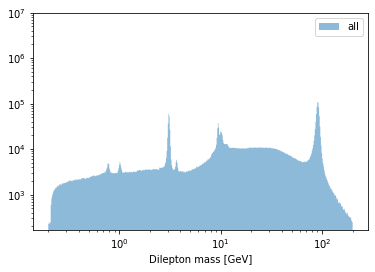

In [48]:
opts = dict(
    bins=np.geomspace(0.2, 200, 500),
    histtype="stepfilled", alpha=0.5
)
plt.hist(np.concatenate(m_list_all) / GeV, label="all", **opts);
#plt.hist(np.concatenate(m_list_baseline) / GeV, label="after baseline selection", **opts);
plt.yscale("log")
plt.xscale("log")
plt.xlabel("Dilepton mass [GeV]")
plt.legend()
plt.ylim(0, 1e7)